# Hackaton : Fraud Bancaire

## Data Preparation (Feature Engineering)


## DATA PREPARATION / FEATURE ENGINEERING
### Auteurs : Hiba & Lisa


**Chargement des fichiers CSV et JSON**

In [7]:
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")

print(" Chargement des fichiers CSV et JSON...")

# CSV
transactions = pd.read_csv("transactions_train.csv")
cards = pd.read_csv("cards_data.csv")
users = pd.read_csv("users_data.csv")

# JSON : codes MCC
with open("mcc_codes.json") as f:
    mcc_codes = json.load(f)
mcc_df = pd.DataFrame(list(mcc_codes.items()), columns=["mcc", "mcc_description"])

# JSON : labels de fraude
with open("train_fraud_labels.json") as f:
    fraud_labels = json.load(f)

# Transformation du JSON de labels en DataFrame
fraud_df = pd.DataFrame(list(fraud_labels["target"].items()), columns=["transaction_id", "fraud"])
fraud_df["fraud"] = fraud_df["fraud"].map({"Yes": 1, "No": 0})

print("Chargement terminé !")


 Chargement des fichiers CSV et JSON...
Chargement terminé !


**APERÇU DES DONNÉES**

In [8]:
print("\nTransactions : ", transactions.shape)
print("Cards        : ", cards.shape)
print("Users        : ", users.shape)
print("MCC codes    : ", mcc_df.shape)
print("Fraud labels : ", fraud_df.shape)

display(transactions.head(2))
display(cards.head(2))
display(users.head(2))
display(mcc_df.head(2))
display(fraud_df.head(2))



Transactions :  (210000, 12)
Cards        :  (6146, 13)
Users        :  (2000, 14)
MCC codes    :  (109, 2)
Fraud labels :  (210000, 2)


,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,19765990,2017-07-07 09:53:00,1581,2519,$12.35,Chip Transaction,20519,Arnold,MO,63010.0,5942,NaN
1,22160255,2018-11-26 17:44:00,1862,4049,$58.29,Chip Transaction,98648,Des Moines,IA,50313.0,5814,NaN


,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5


,mcc,mcc_description
0,5812,Eating Places and Restaurants
1,5541,Service Stations


,transaction_id,fraud
0,19765990,0
1,22160255,0


**NETTOYAGE DE DONNEES**

**1. Nettoyage du fichier transactions**

In [11]:
print("transactions - dimensions avant nettoyage :", transactions.shape)
print(transactions.info())

# suppression des doublons
transactions.drop_duplicates(inplace=True)

# nettoyage de la colonne 'amount' (retrait du signe $ et conversion en float)
transactions['amount'] = (
    transactions['amount']
    .astype(str)                          # s'assurer que tout est du texte
    .str.replace('$', '', regex=False)    # enlever le symbole $
    .str.replace(',', '', regex=False)    # au cas où certaines valeurs aient des virgules
    .astype(float)                        # convertir en nombre
)

# gestion des valeurs manquantes
transactions = transactions.dropna(subset=['transaction_id', 'card_id'])
transactions['amount'] = transactions['amount'].fillna(transactions['amount'].median())

# correction des montants négatifs ou aberrants
transactions = transactions[transactions['amount'] >= 0]

# conversion des dates
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')

# suppression des lignes sans date valide
transactions = transactions.dropna(subset=['date'])

# vérification finale
transactions = transactions.drop_duplicates(subset=['transaction_id'])
print("transactions - dimensions après nettoyage :", transactions.shape)


transactions - dimensions avant nettoyage : (199872, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 199872 entries, 0 to 209999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   transaction_id  199872 non-null  int64         
 1   date            199872 non-null  datetime64[ns]
 2   client_id       199872 non-null  int64         
 3   card_id         199872 non-null  int64         
 4   amount          199872 non-null  float64       
 5   use_chip        199872 non-null  object        
 6   merchant_id     199872 non-null  int64         
 7   merchant_city   199872 non-null  object        
 8   merchant_state  174596 non-null  object        
 9   zip             173349 non-null  float64       
 10  mcc             199872 non-null  int64         
 11  errors          3108 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 19.8+ MB
None
transact

**2. Nettoyage du fichier cards**

In [12]:
print("\ncards - dimensions avant nettoyage :", cards.shape)
print(cards.info())

# suppression des doublons basés sur l'id de carte
cards.drop_duplicates(subset=['id'], inplace=True)

# nettoyage de la colonne 'credit_limit' (retrait du signe $ et conversion en float)
cards['credit_limit'] = (
    cards['credit_limit']
    .astype(str)
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# gestion des valeurs manquantes
cards['card_brand'] = cards['card_brand'].fillna('unknown')
cards['card_type'] = cards['card_type'].fillna('unknown')
cards['has_chip'] = cards['has_chip'].fillna('unknown')
cards['num_cards_issued'] = cards['num_cards_issued'].fillna(0).astype(int)
cards['credit_limit'] = cards['credit_limit'].fillna(cards['credit_limit'].median())

# conversion des dates
cards['acct_open_date'] = pd.to_datetime(cards['acct_open_date'], errors='coerce')
cards['year_pin_last_changed'] = pd.to_numeric(cards['year_pin_last_changed'], errors='coerce')

# nettoyage de la colonne 'expires' (format MM/YYYY → fin du mois correspondant)
cards['expires'] = pd.to_datetime(
    cards['expires'], format='%m/%Y', errors='coerce'
) + pd.offsets.MonthEnd(0)

# suppression des cartes sans id valide
cards = cards.dropna(subset=['id', 'client_id'])

# vérification finale
cards.drop_duplicates(subset=['id'], inplace=True)
print("cards - dimensions après nettoyage :", cards.shape)



cards - dimensions avant nettoyage : (6146, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB
None
cards - dimensions apr

**3. Nettoyage du fichier users**

In [14]:
print("\nusers - dimensions avant nettoyage :", users.shape)
print(users.info())

# suppression des doublons basés sur l'id utilisateur
users.drop_duplicates(subset=['id'], inplace=True)

# gestion des valeurs manquantes
users['gender'] = users['gender'].fillna('unknown')
users['address'] = users['address'].fillna('unknown')

# nettoyage des âges
users['current_age'] = pd.to_numeric(users['current_age'], errors='coerce')
users['retirement_age'] = pd.to_numeric(users['retirement_age'], errors='coerce')
users['birth_year'] = pd.to_numeric(users['birth_year'], errors='coerce')
users['birth_month'] = pd.to_numeric(users['birth_month'], errors='coerce')

# remplacement des valeurs manquantes d'âge par la médiane
users['current_age'] = users['current_age'].fillna(users['current_age'].median())
users['retirement_age'] = users['retirement_age'].fillna(users['retirement_age'].median())

# bornage raisonnable des âges
users = users[(users['current_age'] >= 18) & (users['current_age'] <= 100)]

# nettoyage des coordonnées géographiques
users['latitude'] = pd.to_numeric(users['latitude'], errors='coerce')
users['longitude'] = pd.to_numeric(users['longitude'], errors='coerce')

# nettoyage des valeurs financières (retrait du signe $ et conversion en float)
for col in ['per_capita_income', 'yearly_income', 'total_debt']:
    users[col] = (
        users[col]
        .astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .astype(float)
    )

# gestion des valeurs manquantes pour les revenus et dettes
users['per_capita_income'] = users['per_capita_income'].fillna(users['per_capita_income'].median())
users['yearly_income'] = users['yearly_income'].fillna(users['yearly_income'].median())
users['total_debt'] = users['total_debt'].fillna(users['total_debt'].median())

# nettoyage du credit score
users['credit_score'] = pd.to_numeric(users['credit_score'], errors='coerce')
users['credit_score'] = users['credit_score'].fillna(users['credit_score'].median())

# nettoyage du nombre de cartes de crédit
users['num_credit_cards'] = pd.to_numeric(users['num_credit_cards'], errors='coerce').fillna(0).astype(int)

# suppression des lignes sans id valide
users = users.dropna(subset=['id'])

# vérification finale
users.drop_duplicates(subset=['id'], inplace=True)
print("users - dimensions après nettoyage :", users.shape)



users - dimensions avant nettoyage : (1999, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1999 non-null   int64  
 1   current_age        1999 non-null   int64  
 2   retirement_age     1999 non-null   int64  
 3   birth_year         1999 non-null   int64  
 4   birth_month        1999 non-null   int64  
 5   gender             1999 non-null   object 
 6   address            1999 non-null   object 
 7   latitude           1999 non-null   float64
 8   longitude          1999 non-null   float64
 9   per_capita_income  1999 non-null   float64
 10  yearly_income      1999 non-null   float64
 11  total_debt         1999 non-null   float64
 12  credit_score       1999 non-null   int64  
 13  num_credit_cards   1999 non-null   int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 234.3+ KB
None
users - dime

**4. Nettoyage des fichiers JSON**

a. MCC

In [17]:
with open('mcc_codes.json', 'r') as f:
    mcc_data = json.load(f)

with open('train_fraud_labels.json', 'r') as f:
    fraud_data = json.load(f)

if isinstance(mcc_data, dict):
    mcc = pd.DataFrame(list(mcc_data.items()), columns=['mcc', 'mcc_description'])
else:
    mcc = pd.DataFrame(mcc_data)

mcc.drop_duplicates(subset=['mcc'], inplace=True)
mcc.dropna(subset=['mcc'], inplace=True)
mcc['mcc_description'] = mcc['mcc_description'].astype(str).str.strip()

# train_fraud_labels.json : clé = transaction_id, valeur = Yes/No
fraud = pd.DataFrame(list(fraud_data['target'].items()), columns=['transaction_id', 'fraud'])
fraud['fraud'] = fraud['fraud'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

fraud.drop_duplicates(subset=['transaction_id'], inplace=True)
fraud.dropna(subset=['transaction_id'], inplace=True)

print("mcc shape :", mcc.shape)
print("fraud shape :", fraud.shape)


mcc shape : (109, 2)
fraud shape : (210000, 2)


In [18]:
# nettoyage du fichier merchant categories (mcc_codes.json)

# conversion de la colonne mcc en numérique
mcc['mcc'] = pd.to_numeric(mcc['mcc'], errors='coerce')

# suppression des mcc invalides
mcc = mcc.dropna(subset=['mcc'])
import json
import pandas as pd

# chargement du fichier json
with open('train_fraud_labels.json', 'r') as f:
    fraud_data = json.load(f)

# extraction du dictionnaire 'target' (clé = transaction_id, valeur = Yes/No)
fraud = pd.DataFrame(list(fraud_data['target'].items()), columns=['transaction_id', 'fraud'])

# conversion des labels en numérique : Yes -> 1, No -> 0
fraud['fraud'] = fraud['fraud'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

# suppression des doublons et des valeurs manquantes
fraud.drop_duplicates(subset=['transaction_id'], inplace=True)
fraud.dropna(subset=['transaction_id'], inplace=True)

# affichage d’un aperçu
print("fraud labels nettoyé :", fraud.shape)
print(fraud.head())

# suppression des doublons sur le code mcc
mcc.drop_duplicates(subset=['mcc'], inplace=True)

# nettoyage du texte de la description
mcc['mcc_description'] = (
    mcc['mcc_description']
    .astype(str)
    .str.strip()
    .str.lower()
)

# vérification finale
print("mcc nettoyé :", mcc.shape)
print(mcc.head())


mcc nettoyé : (109, 2)
    mcc                       mcc_description
0  5812         eating places and restaurants
1  5541                      service stations
2  7996  amusement parks, carnivals, circuses
3  5411          grocery stores, supermarkets
4  4784                 tolls and bridge fees


- harmonise les descriptions (tout en minuscules, sans espaces inutiles),

- prépare la colonne mcc pour être fusionnée proprement avec la table des transactions.




b. Fraud Labels

In [19]:
# chargement du fichier json
with open('train_fraud_labels.json', 'r') as f:
    fraud_data = json.load(f)

# extraction du dictionnaire 'target' (clé = transaction_id, valeur = Yes/No)
fraud = pd.DataFrame(list(fraud_data['target'].items()), columns=['transaction_id', 'fraud'])

# conversion des labels en numérique : Yes -> 1, No -> 0
fraud['fraud'] = fraud['fraud'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

# suppression des doublons et des valeurs manquantes
fraud.drop_duplicates(subset=['transaction_id'], inplace=True)
fraud.dropna(subset=['transaction_id'], inplace=True)

# affichage d’un aperçu
print("fraud labels nettoyé :", fraud.shape)
print(fraud.head())


fraud labels nettoyé : (210000, 2)
  transaction_id  fraud
0       19765990      0
1       22160255      0
2       17566794      0
3       17318690      0
4       20994060      0


**Fusion finale des fichiers nettoyés (transactions, cartes, utilisateurs, mcc et fraude)**

In [28]:
# fusion finale des fichiers nettoyés (transactions, cartes, utilisateurs, mcc et fraude)

# harmonisation du type de transaction_id avant la fusion
transactions['transaction_id'] = transactions['transaction_id'].astype(str)
fraud['transaction_id'] = fraud['transaction_id'].astype(str)

# fusion des transactions avec les labels de fraude
merged_df = transactions.merge(fraud, on='transaction_id', how='left')

# fusion avec les cartes
merged_df = merged_df.merge(
    cards,
    left_on='card_id',
    right_on='id',
    how='left',
    suffixes=('', '_card')
)

# fusion avec les utilisateurs
merged_df = merged_df.merge(
    users,
    left_on='client_id',
    right_on='id',
    how='left',
    suffixes=('', '_user')
)

# fusion avec les codes marchands
merged_df = merged_df.merge(mcc, on='mcc', how='left')

In [30]:
# gestion des valeurs manquantes
merged_df['fraud'] = merged_df['fraud'].fillna(0).astype(int)
merged_df['mcc_description'] = merged_df['mcc_description'].fillna('unknown')

# vérification finale
print("forme finale du fichier fusionné :", merged_df.shape)
print(merged_df.info())

# sauvegarde du fichier fusionné
merged_df.to_csv('merged_dataset.csv', index=False)
print("fichier 'merged_dataset.csv' sauvegardé avec succès.")




forme finale du fichier fusionné : (199607, 32)
<class 'pandas.core.frame.DataFrame'>
Index: 199607 entries, 0 to 199871
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               199607 non-null  datetime64[ns]
 1   card_id            199607 non-null  int64         
 2   amount             199607 non-null  float64       
 3   use_chip           199607 non-null  object        
 4   merchant_id        199607 non-null  int64         
 5   merchant_city      199607 non-null  object        
 6   merchant_state     174338 non-null  object        
 7   zip                173091 non-null  float64       
 8   mcc                199607 non-null  int64         
 9   errors             3093 non-null    object        
 10  fraud              199607 non-null  int64         
 11  id                 199607 non-null  int64         
 12  client_id_card     199607 non-null  int64         
 13  c

In [27]:
# nettoyage complémentaire avant le feature engineering

# suppression des colonnes inutiles
cols_to_drop = [
    'transaction_id', 'id_card', 'id_user', 'client_id', 'card_number',
    'cvv', 'address', 'merchant_name', 'acct_open_date',
    'year_pin_last_changed', 'expires'
]

for col in cols_to_drop:
    if col in merged_df.columns:
        merged_df.drop(columns=[col], inplace=True)

# suppression des lignes avec trop de valeurs manquantes
merged_df = merged_df.dropna(thresh=len(merged_df.columns) * 0.8)

# suppression des lignes avec valeurs critiques manquantes
merged_df = merged_df.dropna(subset=['amount', 'mcc', 'date'])

# suppression des doublons restants
merged_df.drop_duplicates(inplace=True)

print("forme après nettoyage complémentaire :", merged_df.shape)


forme après nettoyage complémentaire : (199607, 32)


In [32]:
# vérification et correction des types
numeric_cols = ['amount', 'mcc', 'log_amount', 'mcc_encoded']
for col in numeric_cols:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
merged_df = merged_df.dropna(subset=['date'])


**Feature Engineering**

In [34]:
# début du feature engineering : création de nouvelles variables

import numpy as np

# transformation du montant (pour réduire l'effet des valeurs extrêmes)
merged_df['log_amount'] = np.log1p(merged_df['amount'])

# extraction des composantes temporelles
merged_df['hour'] = merged_df['date'].dt.hour
merged_df['day'] = merged_df['date'].dt.day
merged_df['month'] = merged_df['date'].dt.month
merged_df['year'] = merged_df['date'].dt.year
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
merged_df['is_weekend'] = merged_df['day_of_week'].isin([5, 6]).astype(int)

# encodage fréquentiel du code marchand (MCC)
mcc_freq = merged_df['mcc'].value_counts(normalize=True)
merged_df['mcc_encoded'] = merged_df['mcc'].map(mcc_freq)

# création d'une variable binaire indiquant si le marchand est en ligne
if 'mcc_description' in merged_df.columns:
    merged_df['is_online'] = merged_df['mcc_description'].str.contains('online', case=False, na=False).astype(int)
else:
    merged_df['is_online'] = 0

# variable indiquant si la transaction est effectuée la nuit (heures creuses)
merged_df['is_night'] = merged_df['hour'].isin([0, 1, 2, 3, 4, 5]).astype(int)

# rapport entre montant et limite de carte (utile pour détecter les anomalies)
if 'credit_limit' in merged_df.columns:
    merged_df['amount_ratio_limit'] = merged_df['amount'] / (merged_df['credit_limit'] + 1)
else:
    merged_df['amount_ratio_limit'] = 0

# normalisation simple des valeurs aberrantes du ratio
merged_df['amount_ratio_limit'] = merged_df['amount_ratio_limit'].clip(0, 10)

# gestion des valeurs manquantes restantes
merged_df = merged_df.fillna({
    'hour': 0, 'day': 0, 'month': 0, 'year': 0,
    'day_of_week': 0, 'mcc_encoded': 0,
    'is_online': 0, 'is_night': 0, 'amount_ratio_limit': 0
})

print("nouvelles variables créées avec succès")
print(merged_df[['amount', 'log_amount', 'hour', 'is_weekend', 'mcc_encoded', 'is_online', 'is_night', 'amount_ratio_limit']].head())



nouvelles variables créées avec succès
   amount  log_amount  hour  is_weekend  mcc_encoded  is_online  is_night  \
0   12.35    2.591516     9           0     0.019022          0         0   
1   58.29    4.082441    17           0     0.039292          0         0   
2   11.03    2.487404    12           1     0.128357          0         0   
3   85.74    4.462915     8           0     0.128357          0         0   
4   13.43    2.669309    14           1     0.008877          0         0   

   amount_ratio_limit  
0            0.000464  
1            0.005714  
2            0.000289  
3            0.002445  
4            0.002315  


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [37]:
# transformation du montant pour réduire l'effet des valeurs extrêmes
merged_df['log_amount'] = np.log1p(merged_df['amount'])

# extraction des informations temporelles à partir de la date
merged_df['hour'] = merged_df['date'].dt.hour
merged_df['day'] = merged_df['date'].dt.day
merged_df['month'] = merged_df['date'].dt.month
merged_df['year'] = merged_df['date'].dt.year
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
merged_df['is_weekend'] = merged_df['day_of_week'].isin([5, 6]).astype(int)

# encodage fréquentiel du code marchand (mcc)
mcc_freq = merged_df['mcc'].value_counts(normalize=True)
merged_df['mcc_encoded'] = merged_df['mcc'].map(mcc_freq)

In [38]:
# variable binaire : transaction en ligne (présence du mot "online" dans la description)
merged_df['is_online'] = merged_df['mcc_description'].str.contains('online', case=False, na=False).astype(int)

# variable binaire : transaction de nuit
merged_df['is_night'] = merged_df['hour'].isin([0, 1, 2, 3, 4, 5]).astype(int)

# ratio entre montant et limite de carte
if 'credit_limit' in merged_df.columns:
    merged_df['amount_ratio_limit'] = merged_df['amount'] / (merged_df['credit_limit'] + 1)
    merged_df['amount_ratio_limit'] = merged_df['amount_ratio_limit'].clip(0, 10)
else:
    merged_df['amount_ratio_limit'] = 0

In [39]:
# remplacement des valeurs manquantes restantes
merged_df.fillna({
    'hour': 0,
    'day': 0,
    'month': 0,
    'year': 0,
    'day_of_week': 0,
    'mcc_encoded': 0,
    'is_online': 0,
    'is_night': 0,
    'amount_ratio_limit': 0
}, inplace=True)

nouvelles variables créées :


,variable,type,nb_valeurs_uniques,valeurs_manquantes
0,log_amount,float64,20960,0
1,hour,int32,24,0
2,day,int32,31,0
3,month,int32,12,0
4,year,int32,3,0
5,day_of_week,int32,7,0
6,is_weekend,int64,2,0
7,mcc_encoded,float64,101,0
8,is_online,int64,1,0
9,is_night,int64,2,0



apercu du jeu de données enrichi :


,log_amount,hour,day,month,year,day_of_week,is_weekend,mcc_encoded,is_online,is_night,amount_ratio_limit,fraud
0,2.591516,9,7,7,2017,4,0,0.019022,0,0,0.000464,0
1,4.082441,17,26,11,2018,0,0,0.039292,0,0,0.005714,0
2,2.487404,12,26,3,2016,5,1,0.128357,0,0,0.000289,0
3,4.462915,8,1,2,2016,0,0,0.128357,0,0,0.002445,0
4,2.669309,14,24,3,2018,5,1,0.008877,0,0,0.002315,0
5,3.991204,22,9,12,2017,5,1,0.020791,0,0,0.003018,0
6,3.986388,21,1,10,2016,5,1,0.128357,0,0,0.007660,0
7,3.592644,12,23,10,2018,1,0,0.020791,0,0,0.001821,0
8,5.245813,9,21,1,2017,5,1,0.016683,0,0,0.015862,0
9,3.346389,13,16,1,2016,5,1,0.040905,0,0,0.001968,0


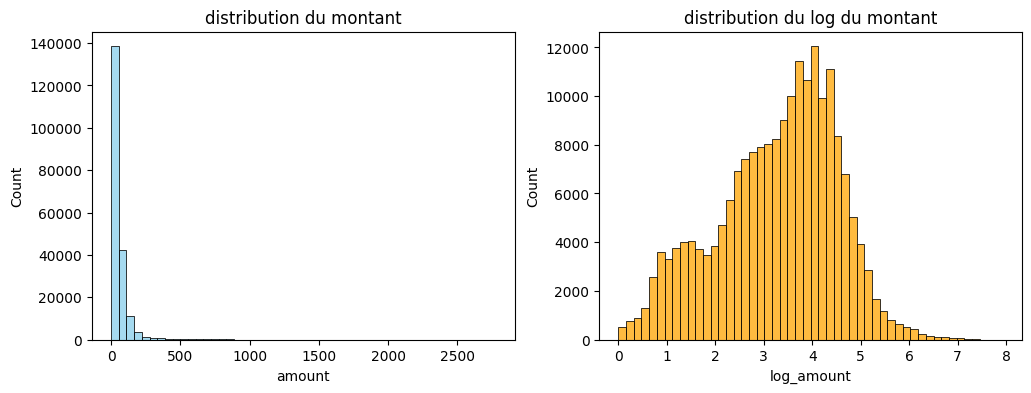

In [40]:
# affichage d’un résumé des nouvelles variables
features_created = ['log_amount', 'hour', 'day', 'month', 'year', 'day_of_week',
                    'is_weekend', 'mcc_encoded', 'is_online', 'is_night', 'amount_ratio_limit']

print("nouvelles variables créées :")
display(pd.DataFrame({
    'variable': features_created,
    'type': [merged_df[col].dtype for col in features_created],
    'nb_valeurs_uniques': [merged_df[col].nunique() for col in features_created],
    'valeurs_manquantes': [merged_df[col].isna().sum() for col in features_created]
}))

# aperçu des premières lignes
print("\napercu du jeu de données enrichi :")
display(merged_df[features_created + ['fraud']].head(10))

# visualisation : distribution du montant et du log montant
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(merged_df['amount'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title("distribution du montant")
sns.histplot(merged_df['log_amount'], bins=50, ax=axes[1], color='orange')
axes[1].set_title("distribution du log du montant")
plt.show()

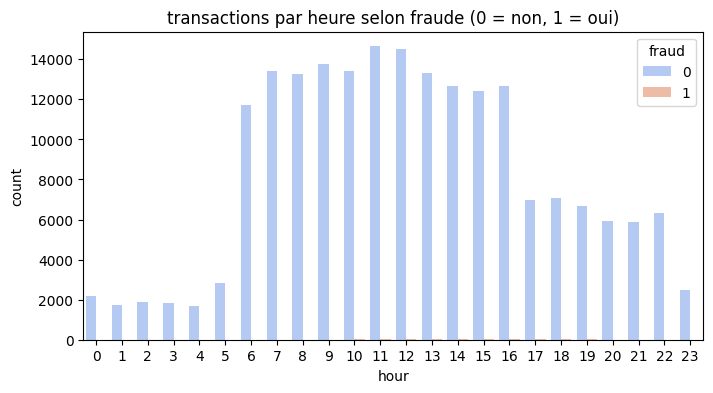

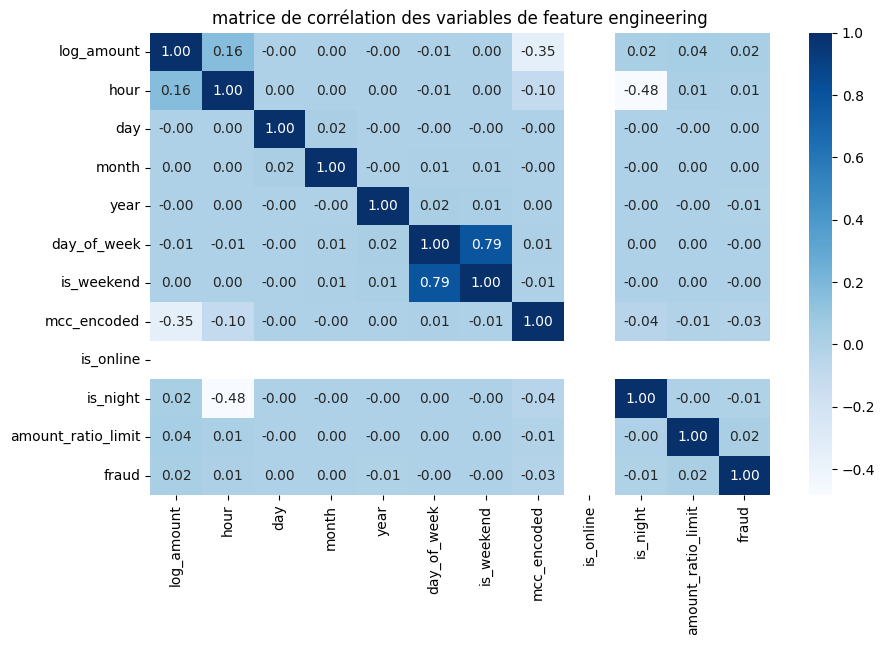

In [41]:
# visualisation : répartition des heures selon la fraude
plt.figure(figsize=(8,4))
sns.countplot(data=merged_df, x='hour', hue='fraud', palette='coolwarm')
plt.title("transactions par heure selon fraude (0 = non, 1 = oui)")
plt.show()

# corrélation entre les principales variables numériques
plt.figure(figsize=(10,6))
corr = merged_df[features_created + ['fraud']].corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title("matrice de corrélation des variables de feature engineering")
plt.show()

| variable_origine      | nouvelle_variable  | type_transformation                     | objectif                                |
| --------------------- | ------------------ | --------------------------------------- | --------------------------------------- |
| amount                | log_amount         | transformation logarithmique            | réduire l’impact des montants extrêmes  |
| date                  | hour               | extraction de l’heure                   | analyser les habitudes horaires         |
| date                  | day                | extraction du jour du mois              | étudier les comportements journaliers   |
| date                  | month              | extraction du mois                      | détecter des variations saisonnières    |
| date                  | year               | extraction de l’année                   | suivre les tendances temporelles        |
| date                  | day_of_week        | extraction du jour de la semaine        | repérer les schémas hebdomadaires       |
| date                  | is_weekend         | création d’une variable binaire         | identifier les transactions du week-end |
| mcc                   | mcc_encoded        | encodage fréquentiel                    | représenter le type de marchand         |
| mcc_description       | is_online          | détection du mot “online”               | repérer les transactions e-commerce     |
| date                  | is_night           | création d’une variable binaire (0h–5h) | repérer les transactions nocturnes      |
| amount + credit_limit | amount_ratio_limit | calcul de ratio                         | détecter les montants disproportionnés  |


De nouvelles variables ont été créées à partir des montants, dates, codes marchands et limites de crédit.

Elles capturent des aspects temporels (heure, jour, week-end, nuit), comportementaux (achats en ligne, fréquence MCC) et financiers (montant logarithmique, ratio montant/limite).

Ces transformations visent à mieux différencier les transactions normales des fraudes potentielles.

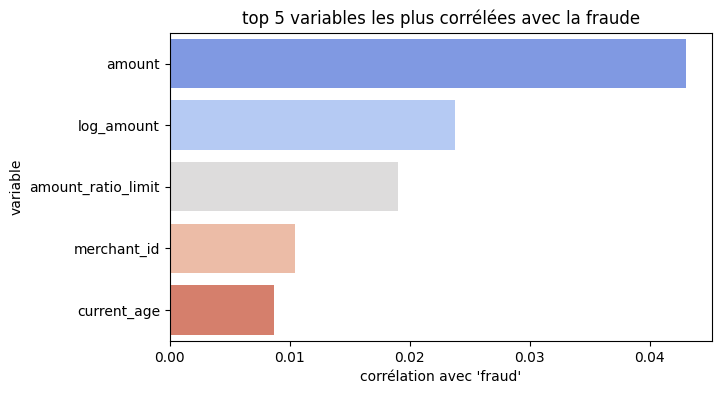

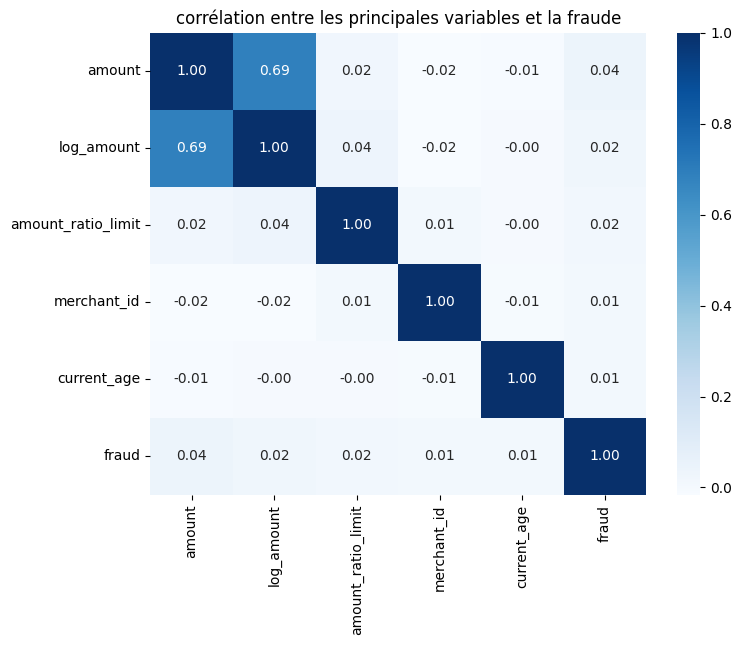

In [42]:
# calcul des corrélations avec la variable cible
corr_with_fraud = merged_df.corr(numeric_only=True)['fraud'].sort_values(ascending=False)

# top 5 variables les plus corrélées avec la fraude (hors 'fraud' elle-même)
top_features = corr_with_fraud.drop('fraud').head(5)

plt.figure(figsize=(7, 4))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')
plt.title("top 5 variables les plus corrélées avec la fraude")
plt.xlabel("corrélation avec 'fraud'")
plt.ylabel("variable")
plt.show()

# matrice de corrélation simplifiée
plt.figure(figsize=(8,6))
sns.heatmap(
    merged_df[top_features.index.tolist() + ['fraud']].corr(),
    annot=True, cmap='Blues', fmt='.2f'
)
plt.title("corrélation entre les principales variables et la fraude")
plt.show()


-> un bar chart du top 5 des variables les plus corrélées à la fraude,

-> une mini matrice de corrélation pour visualiser leurs interactions.